# RecSys RetailRocket

## Setup

In [ ]:
# !pip install -q -U kaggle
# !pip install --upgrade --force-reinstall --no-deps kaggle
# !mkdir ~/.kaggle
# !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# # !kaggle datasets list

In [ ]:
!kaggle datasets download -d retailrocket/ecommerce-dataset
!mkdir -p ./data && unzip ecommerce-dataset.zip
!mv ./*.csv ./data && rm ecommerce-dataset.zip

In [ ]:
import os
import re
import time
import datetime
from tqdm import tqdm

import numpy as np
import pandas as pd

import bz2
import csv
import json
import operator

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## Data Loading

In [ ]:
events_df = pd.read_csv('./data/events.csv')
category_tree_df = pd.read_csv('./data/category_tree.csv')
item_properties_1_df = pd.read_csv('./data/item_properties_part1.csv')
item_properties_2_df = pd.read_csv('./data/item_properties_part2.csv')

In [ ]:
item_prop_df = pd.concat([item_properties_1_df, item_properties_2_df])
item_prop_df.reset_index(drop=True, inplace=True)
del item_properties_1_df
del item_properties_2_df

In [ ]:
events_df.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [ ]:
item_prop_df.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


- Property is the Item's attributes such as category id and availability while the rest are hashed for confidentiality purposes

- Value is the item's property value e.g. availability is 1 if there is stock and 0 otherwise

- Note: Values that start with "n" indicate that the value preceeding it is a number e.g. n277.200 is equal to `277.2`

In [ ]:
category_tree_df.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


## EDA

Q: what are the items under category id `1016`?

In [ ]:
item_prop_df.loc[(item_prop_df.property == 'categoryid') & (item_prop_df.value == '1016')].sort_values('timestamp').head()

,timestamp,itemid,property,value
18236968,1431226800000,6777,categoryid,1016
8597591,1431226800000,161686,categoryid,1016
9496408,1431226800000,276491,categoryid,1016
17880130,1431226800000,443058,categoryid,1016
18202530,1431226800000,462004,categoryid,1016


Q: What is the parent category of `1016`?

In [ ]:
category_tree_df[category_tree_df.categoryid==1016]

,categoryid,parentid
0,1016,213.0


Q: What are items under category `213`?

In [ ]:
item_prop_df.loc[(item_prop_df.property == 'categoryid') & (item_prop_df.value == '213')].sort_values('timestamp').head()

,timestamp,itemid,property,value


visitors who bought something, assuming that there were no repeat users with different visitor IDs

In [ ]:
customer_purchased = events_df[events_df.transactionid.notnull()].visitorid.unique()
all_customers = events_df.visitorid.unique()
customer_browsed = [x for x in all_customers if x not in customer_purchased]
print("%d out of %d"%(len(all_customers)-len(customer_browsed), len(all_customers)))

11719 out of 1407580


Snapshot of a random session with visitor id 102019

In [ ]:
events_df[events_df.visitorid == 102019].sort_values('timestamp')

,timestamp,visitorid,event,itemid,transactionid
19690,1433175714335,102019,view,49521,NaN
19501,1433175801314,102019,addtocart,49521,NaN
14842,1433175812596,102019,view,150318,NaN
19573,1433175871497,102019,view,49521,NaN
8701,1433175894837,102019,view,49521,NaN
19708,1433175945872,102019,view,150318,NaN
8740,1433176042269,102019,view,49521,NaN
814,1433176736375,102019,transaction,150318,13556.0
19724,1433176736422,102019,transaction,49521,13556.0


In [ ]:
def _todatetime(dt):
  return datetime.datetime.fromtimestamp(int(dt/1000)).strftime('%Y-%m-%d %H:%M:%S')

print('Range of transaction dates = ', _todatetime(events_df['timestamp'].min()), 'to', _todatetime(events_df['timestamp'].max()))

Range of transaction dates =  2015-05-03 03:00:04 to 2015-09-18 02:59:47


## Preprocessing

In [ ]:
def preprocess_events(df):

  # convert unix time to pandas datetime
  df['date'] = pd.to_datetime(df['timestamp'], unit='ms', origin='unix')
  
  # label the events
  # events.event.replace(to_replace=dict(view=1, addtocart=2, transaction=3), inplace=True)

  # convert event to categorical
  df['event_type'] = df['event'].astype('category')

  # # drop the transcationid and timestamp columns
  # df.drop(['transactionid', 'timestamp'], axis=1, inplace=True)

  # # label encode
  # le_users = LabelEncoder()
  # le_items = LabelEncoder()
  # events['visitorid'] = le_users.fit_transform(events['visitorid'])
  # events['itemid'] = le_items.fit_transform(events['itemid'])
  
  # return train, valid, test
  return df

In [ ]:
events_processed = preprocess_events(events_df)
events_processed.head()

,timestamp,visitorid,event,itemid,transactionid,date,event_type
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117,view
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164,view
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827,view
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914,view
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106,view


In [ ]:
dfx = events_df.sample(frac=0.01)

In [ ]:
def sessionize(events_df: pd.DataFrame):

  session_duration = datetime.timedelta(minutes=30)
  gpby_visitorid = events_df.groupby('visitorid')

  session_list = []
  for a_visitorid in gpby_visitorid.groups:

    visitor_df = events_df.loc[gpby_visitorid.groups[a_visitorid], :].sort_values('date')
    if not visitor_df.empty:
        visitor_df.sort_values('date', inplace=True)

        # Initialise first session
        startdate = visitor_df.iloc[0, :]['date']
        visitorid = a_visitorid
        items_dict = dict([ (i, []) for i in events_df['event_type'].cat.categories ])
        for index, row in visitor_df.iterrows():

            # Check if current event date is within session duration
            if row['date'] - startdate <= session_duration:
            # Add itemid to the list according to event type (i.e. view, addtocart or transaction)
                items_dict[row['event']].append(row['itemid'])
                enddate = row['date']
            else:
                # Complete current session
                session_list.append([visitorid, startdate, enddate] + [ value for key, value in items_dict.items() ])
                # Start a new session
                startdate = row['date']
                items_dict = dict([ (i, []) for i in events_df['event_type'].cat.categories ])
                # Add current itemid
                items_dict[row['event']].append(row['itemid'])

        # If dict if not empty, add item data as last session.
        incomplete_session = False
        for key, value in items_dict.items():
            if value:
                incomplete_session = True
                break
        if incomplete_session:
            session_list.append([visitorid, startdate, enddate] + [value for key, value in items_dict.items()])

  return session_list

In [ ]:
session_list = sessionize(dfx)
sessions_df = pd.DataFrame(session_list, columns=['visitorid', 'startdate', 'enddate', 'addtocart', 'transaction', 'view'])
sessions_df.head()

,visitorid,startdate,enddate,addtocart,transaction,view
0,24,2015-05-22 18:21:49.615,2015-05-22 18:21:49.615,[],[],[346051]
1,27,2015-07-24 08:51:19.750,2015-07-24 08:51:19.750,[],[],[314714]
2,64,2015-06-15 22:58:56.974,2015-06-15 22:58:56.974,[],[],[160984]
3,81,2015-09-10 16:20:45.920,2015-09-10 16:20:45.920,[],[],[337512]
4,150,2015-06-07 23:26:40.541,2015-06-07 23:26:40.541,[],[],[186933]


In [ ]:
class BaseDataset(object):
    def __init__(self, input_path, output_path):
        super(BaseDataset, self).__init__()

        self.dataset_name = ''
        self.input_path = input_path
        self.output_path = output_path
        self.check_output_path()

        # input file
        self.inter_file = os.path.join(self.input_path, 'inters.dat')
        self.item_file = os.path.join(self.input_path, 'items.dat')
        self.user_file = os.path.join(self.input_path, 'users.dat')
        self.sep = '\t'

        # output file
        self.output_inter_file, self.output_item_file, self.output_user_file = self.get_output_files()

        # selected feature fields
        self.inter_fields = {}
        self.item_fields = {}
        self.user_fields = {}

    def check_output_path(self):
        if not os.path.isdir(self.output_path):
            os.makedirs(self.output_path)

    def get_output_files(self):
        output_inter_file = os.path.join(self.output_path, self.dataset_name + '.inter')
        output_item_file = os.path.join(self.output_path, self.dataset_name + '.item')
        output_user_file = os.path.join(self.output_path, self.dataset_name + '.user')
        return output_inter_file, output_item_file, output_user_file

    def load_inter_data(self) -> pd.DataFrame():
        raise NotImplementedError

    def load_item_data(self) -> pd.DataFrame():
        raise NotImplementedError

    def load_user_data(self) -> pd.DataFrame():
        raise NotImplementedError

    def convert_inter(self):
        try:
            input_inter_data = self.load_inter_data()
            self.convert(input_inter_data, self.inter_fields, self.output_inter_file)
        except NotImplementedError:
            print('This dataset can\'t be converted to inter file\n')

    def convert_item(self):
        try:
            input_item_data = self.load_item_data()
            self.convert(input_item_data, self.item_fields, self.output_item_file)
        except NotImplementedError:
            print('This dataset can\'t be converted to item file\n')

    def convert_user(self):
        try:
            input_user_data = self.load_user_data()
            self.convert(input_user_data, self.user_fields, self.output_user_file)
        except NotImplementedError:
            print('This dataset can\'t be converted to user file\n')

    @staticmethod
    def convert(input_data, selected_fields, output_file):
        output_data = pd.DataFrame()
        for column in selected_fields:
            output_data[column] = input_data.iloc[:, column]
        with open(output_file, 'w') as fp:
            fp.write('\t'.join([selected_fields[column] for column in output_data.columns]) + '\n')
            for i in tqdm(range(output_data.shape[0])):
                fp.write('\t'.join([str(output_data.iloc[i, j])
                                    for j in range(output_data.shape[1])]) + '\n')

    def parse_json(self, data_path):
        with open(data_path, 'rb') as g:
            for l in g:
                yield eval(l)

    def getDF(self, data_path):
        i = 0
        df = {}
        for d in self.parse_json(data_path):
            df[i] = d
            i += 1
        data = pd.DataFrame.from_dict(df, orient='index')
        
        return data

In [ ]:
class RETAILROCKETDataset(BaseDataset):
    def __init__(self, input_path, output_path, interaction_type, duplicate_removal):
        super(RETAILROCKETDataset, self).__init__(input_path, output_path)
        self.dataset_name = 'retailrocket'
        self.interaction_type = interaction_type
        assert self.interaction_type in ['view', 'addtocart',
                                         'transaction'], 'interaction_type must be in [view, addtocart, transaction]'
        self.duplicate_removal = duplicate_removal

        # input file
        self.inter_file = os.path.join(self.input_path, 'events.csv')
        self.item_file1 = os.path.join(self.input_path, 'item_properties_part1.csv')
        self.item_file2 = os.path.join(self.input_path, 'item_properties_part2.csv')
        self.sep = ','

        # output file
        if self.interaction_type == 'view':
            self.output_inter_file = os.path.join(self.output_path, 'retailrocket-view.inter')
        elif self.interaction_type == 'addtocart':
            self.output_inter_file = os.path.join(self.output_path, 'retailrocket-addtocart.inter')
        elif self.interaction_type == 'transaction':
            self.output_inter_file = os.path.join(self.output_path, 'retailrocket-transaction.inter')
        self.output_item_file = os.path.join(self.output_path, 'retailrocket.item')

        # selected feature fields
        if self.duplicate_removal:
            if self.interaction_type == 'view':
                self.inter_fields = {0: 'timestamp:float',
                                     1: 'visitor_id:token',
                                     2: 'item_id:token',
                                     3: 'count:float'}
            elif self.interaction_type == 'addtocart':
                self.inter_fields = {0: 'timestamp:float',
                                     1: 'visitor_id:token',
                                     2: 'item_id:token',
                                     3: 'count:float'}
            elif self.interaction_type == 'transaction':
                self.inter_fields = {0: 'timestamp:float',
                                     1: 'visitor_id:token',
                                     2: 'item_id:token',
                                     3: 'count:float'}
        else:
            if self.interaction_type == 'view':
                self.inter_fields = {0: 'timestamp:float',
                                     1: 'visitor_id:token',
                                     2: 'item_id:token'}
            elif self.interaction_type == 'addtocart':
                self.inter_fields = {0: 'timestamp:float',
                                     1: 'visitor_id:token',
                                     2: 'item_id:token'}
            elif self.interaction_type == 'transaction':
                self.inter_fields = {0: 'timestamp:float',
                                     1: 'visitor_id:token',
                                     2: 'item_id:token',
                                     3: 'transaction_id:token'}
        self.item_fields = {0: 'item_timestamp:float',
                            1: 'item_id:token',
                            2: 'property:token',
                            3: 'value:token_seq'}

    def convert_inter(self):
        if self.duplicate_removal:
            fin = open(self.inter_file, "r")
            fout = open(self.output_inter_file, "w")

            lines_count = 0
            for _ in fin:
                lines_count += 1
            fin.seek(0, 0)

            fout.write('\t'.join([self.inter_fields[column] for column in self.inter_fields.keys()]) + '\n')
            dic = {}

            for i in tqdm(range(lines_count)):
                if i == 0:
                    fin.readline()
                    continue
                line = fin.readline()
                line_list = line.split(',')
                key = (line_list[1], line_list[3])
                if line_list[2] == self.interaction_type:
                    if key not in dic:
                        dic[key] = (line_list[0], 1)
                    else:
                        if line_list[0] > dic[key][0]:
                            dic[key] = (line_list[0], dic[key][1] + 1)
                        else:
                            dic[key] = (dic[key][0], dic[key][1] + 1)

            for key in dic.keys():
                fout.write(dic[key][0] + '\t' + key[0] + '\t' + key[1] + '\t' + str(dic[key][1]) + '\n')

            fin.close()
            fout.close()
        else:
            fin = open(self.inter_file, "r")
            fout = open(self.output_inter_file, "w")

            lines_count = 0
            for _ in fin:
                lines_count += 1
            fin.seek(0, 0)

            fout.write('\t'.join([self.inter_fields[column] for column in self.inter_fields.keys()]) + '\n')

            for i in tqdm(range(lines_count)):
                if i == 0:
                    fin.readline()
                    continue
                line = fin.readline()
                line_list = line.split(',')
                if line_list[2] == self.interaction_type:
                    if self.interaction_type != 'transaction':
                        del line_list[4]
                    else:
                        line_list[4] = line_list[4].strip()
                    del line_list[2]
                    fout.write('\t'.join([str(line_list[i]) for i in range(len(line_list))]) + '\n')

            fin.close()
            fout.close()

    def convert_item(self):
        fin1 = open(self.item_file1, "r")
        fin2 = open(self.item_file2, "r")
        fout = open(self.output_item_file, "w")

        lines_count1 = 0
        for _ in fin1:
            lines_count1 += 1
        fin1.seek(0, 0)

        lines_count2 = 0
        for _ in fin2:
            lines_count2 += 1
        fin2.seek(0, 0)

        fout.write('\t'.join([self.item_fields[column] for column in self.item_fields.keys()]) + '\n')

        for i in tqdm(range(lines_count1)):
            if i == 0:
                line = fin1.readline()
                continue
            line = fin1.readline()
            line_list = line.split(',')
            fout.write('\t'.join([str(line_list[i]) for i in range(len(line_list))]))

        for i in tqdm(range(lines_count2)):
            if i == 0:
                line = fin2.readline()
                continue
            line = fin2.readline()
            line_list = line.split(',')
            fout.write('\t'.join([str(line_list[i]) for i in range(len(line_list))]))

        fin1.close()
        fin2.close()
        fout.close()

In [ ]:
# data_object = RETAILROCKETDataset('./data', '.', 'view', True)
# data_object.convert_inter()
# data_object.convert_item()

100%|██████████| 9275904/9275904 [00:19<00:00, 478121.32it/s]


## Feature Engineering

Page Time

In [ ]:
sessions_df['pages'] = sessions_df['view'].apply(lambda x: len(x))
pages_more_than1 = sessions_df['pages'] > 1
pages_less_than1 = pages_more_than1.apply(lambda x: not x)
sessions_df.loc[pages_more_than1, 'pagetime'] = (sessions_df.loc[pages_more_than1, 'enddate'] - sessions_df.loc[pages_more_than1, 'startdate']) /\
                                                (sessions_df.loc[pages_more_than1, 'pages'] - 1)
sessions_df.loc[pages_less_than1, 'pagetime'] = pd.Timedelta(0)
sessions_df.head(10)

,visitorid,startdate,enddate,addtocart,transaction,view,pages,pagetime
0,24,2015-05-22 18:21:49.615,2015-05-22 18:21:49.615,[],[],[346051],1,0 days
1,27,2015-07-24 08:51:19.750,2015-07-24 08:51:19.750,[],[],[314714],1,0 days
2,64,2015-06-15 22:58:56.974,2015-06-15 22:58:56.974,[],[],[160984],1,0 days
3,81,2015-09-10 16:20:45.920,2015-09-10 16:20:45.920,[],[],[337512],1,0 days
4,150,2015-06-07 23:26:40.541,2015-06-07 23:26:40.541,[],[],[186933],1,0 days
5,224,2015-08-03 05:27:35.713,2015-08-03 05:27:35.713,[],[],[168697],1,0 days
6,255,2015-08-27 07:49:07.215,2015-08-27 07:49:07.215,[],[],[83574],1,0 days
7,264,2015-09-07 17:09:12.830,2015-09-07 17:09:12.830,[],[],[161949],1,0 days
8,295,2015-07-16 22:56:09.078,2015-07-16 22:56:09.078,[],[],[445817],1,0 days
9,301,2015-06-10 21:04:18.505,2015-06-10 21:04:18.505,[],[],[209372],1,0 days


The rule of thumb on creating a simple yet effective recommender system is to downsample the data without losing quality. It means, you can take only maybe 50 latest transactions for each user and you still get the quality you want because behavior changes over-time.

In [ ]:
trans = events_df[events_df['event'] == 'transaction']
trans2 = trans.groupby(['visitorid']).head(50)
trans2

,timestamp,visitorid,event,itemid,transactionid,date,event_type
130,1433222276276,599528,transaction,356475,4000.0,2015-06-02 05:17:56.276,transaction
304,1433193500981,121688,transaction,15335,11117.0,2015-06-01 21:18:20.981,transaction
418,1433193915008,552148,transaction,81345,5444.0,2015-06-01 21:25:15.008,transaction
814,1433176736375,102019,transaction,150318,13556.0,2015-06-01 16:38:56.375,transaction
843,1433174518180,189384,transaction,310791,7244.0,2015-06-01 16:01:58.180,transaction
...,...,...,...,...,...,...,...
2755082,1438388436295,1155978,transaction,430050,4316.0,2015-08-01 00:20:36.295,transaction
2755285,1438380441389,218648,transaction,446271,10485.0,2015-07-31 22:07:21.389,transaction
2755294,1438377176570,1050575,transaction,31640,8354.0,2015-07-31 21:12:56.570,transaction
2755508,1438357730123,855941,transaction,235771,4385.0,2015-07-31 15:48:50.123,transaction


In [ ]:
visitors = trans['visitorid'].unique()
items = trans['itemid'].unique()

trans2['visitors'] = trans2['visitorid'].apply(lambda x : np.argwhere(visitors == x)[0][0])
trans2['items'] = trans2['itemid'].apply(lambda x : np.argwhere(items == x)[0][0])

In [ ]:
trans2.head()

,timestamp,visitorid,event,itemid,transactionid,date,event_type,visitors,items
130,1433222276276,599528,transaction,356475,4000.0,2015-06-02 05:17:56.276,transaction,0,0
304,1433193500981,121688,transaction,15335,11117.0,2015-06-01 21:18:20.981,transaction,1,1
418,1433193915008,552148,transaction,81345,5444.0,2015-06-01 21:25:15.008,transaction,2,2
814,1433176736375,102019,transaction,150318,13556.0,2015-06-01 16:38:56.375,transaction,3,3
843,1433174518180,189384,transaction,310791,7244.0,2015-06-01 16:01:58.180,transaction,4,4


Create the user-item matrix

In [ ]:
from scipy.sparse import csr_matrix

occurences = csr_matrix((visitors.shape[0], items.shape[0]), dtype='int8')

def set_occurences(visitor, item):
    occurences[visitor, item] += 1

trans2.apply(lambda row: set_occurences(row['visitors'], row['items']), axis=1)

occurences

/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


<11719x12025 sparse matrix of type '<class 'numpy.int8'>'
	with 18905 stored elements in Compressed Sparse Row format>

Co-occurrence is a better occurrence

Let’s construct an item-item matrix where each element means how many times both items bought together by a user. Call it the co-occurrence matrix.

In [ ]:
cooc = occurences.transpose().dot(occurences)
cooc.setdiag(0)

In [ ]:
  # split into train, test and valid
  train, test = train_test_split(events, train_size=0.9)
  train, valid = train_test_split(train, train_size=0.9)
  print('Train:{}, Valid:{}, Test:{}'.format(train.shape,
                                            valid.shape,
                                            test.shape))

https://nbviewer.jupyter.org/github/tkokkeng/EB5202-RetailRocket/blob/master/retailrocket-features.ipynb

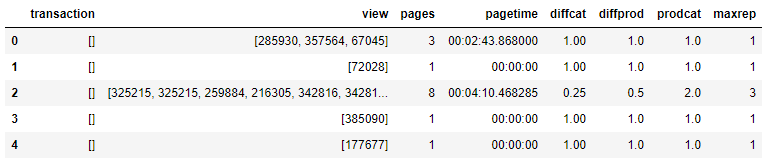

## Matrix factorization model

In [ ]:
# store the number of visitors and items in a variable
n_users = events.visitorid.nunique()
n_items = events.itemid.nunique()

# set the number of latent factors
n_latent_factors = 5

# import the required layers
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, Flatten

# create input layer for items
item_input = Input(shape=[1],name='Items')

# create embedding layer for items
item_embed = Embedding(n_items,
                       n_latent_factors,
                       name='ItemsEmbedding')(item_input)
item_vec = Flatten(name='ItemsFlatten')(item_embed)

# create the input and embedding layer for users also
user_input = Input(shape=[1],name='Users')
user_embed = Embedding(n_users,
                       n_latent_factors, 
                       name='UsersEmbedding')(user_input)
user_vec = Flatten(name='UsersFlatten')(user_embed)

# create a layer for the dot product of both vector space representations
dot_prod = keras.layers.dot([item_vec, user_vec],axes=[1,1],
                             name='DotProduct')

# build and compile the model
model = keras.Model([item_input, user_input], dot_prod)
model.compile('adam', 'mse')
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Items (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
Users (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
ItemsEmbedding (Embedding)      (None, 1, 5)         1175305     Items[0][0]                      
__________________________________________________________________________________________________
UsersEmbedding (Embedding)      (None, 1, 5)         7037900     Users[0][0]                      
____________________________________________________________________________________________

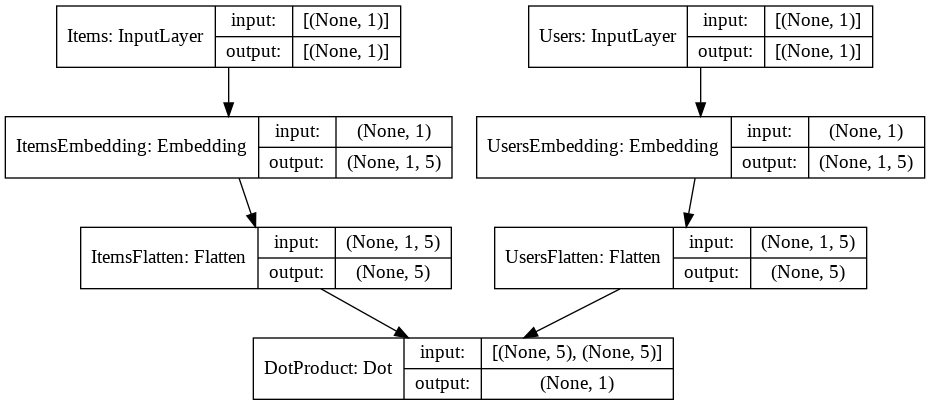

In [ ]:
keras.utils.plot_model(model, 
                       to_file='model.png', 
                       show_shapes=True, 
                       show_layer_names=True)
from IPython import display
display.display(display.Image('model.png'))

In [ ]:
# train and evaluate the model
model.fit([train.visitorid.values, train.itemid.values], train.event.values, epochs=50)
score = model.evaluate([test.visitorid, test.itemid], test.event)
print('mean squared error:', score)

## Neural net model

In [ ]:
n_lf_visitor = 5
n_lf_item = 5

item_input = Input(shape=[1],name='Items')
item_embed = Embedding(n_items + 1,
                           n_lf_visitor, 
                           name='ItemsEmbedding')(item_input)
item_vec = Flatten(name='ItemsFlatten')(item_embed)

visitor_input = Input(shape=[1],name='Visitors')
visitor_embed = Embedding(n_visitors + 1, 
                              n_lf_item,
                              name='VisitorsEmbedding')(visitor_input)
visitor_vec = Flatten(name='VisitorsFlatten')(visitor_embed)

concat = keras.layers.concatenate([item_vec, visitor_vec], name='Concat')
fc_1 = Dense(80,name='FC-1')(concat)
fc_2 = Dense(40,name='FC-2')(fc_1)
fc_3 = Dense(20,name='FC-3', activation='relu')(fc_2)

output = Dense(1, activation='relu',name='Output')(fc_3)

optimizer = keras.optimizers.Adam(lr=0.001)
model = keras.Model([item_input, visitor_input], output)
model.compile(optimizer=optimizer,loss= 'mse')

model.fit([train.visitorid, train.itemid], train.event, epochs=50)
score = model.evaluate([test.visitorid, test.itemid], test.event)
print('mean squared error:', score)

---

In [ ]:
user_activity_count = dict()
for row in events.itertuples():
    if row.visitorid not in user_activity_count:
        user_activity_count[row.visitorid] = {'view':0 , 'addtocart':0, 'transaction':0};
    if row.event == 'addtocart':
        user_activity_count[row.visitorid]['addtocart'] += 1 
    elif row.event == 'transaction':
        user_activity_count[row.visitorid]['transaction'] += 1
    elif row.event == 'view':
        user_activity_count[row.visitorid]['view'] += 1 

d = pd.DataFrame(user_activity_count)
dataframe = d.transpose()

# Activity range
dataframe['activity'] = dataframe['view'] + dataframe['addtocart'] + dataframe['transaction']

# removing users with only a single view
cleaned_data = dataframe[dataframe['activity']!=1]

cleaned_data.head()

,view,addtocart,transaction,activity
257597,2,0,0,2
992329,30,0,0,30
111016,2,0,0,2
483717,3,0,0,3
972639,2,0,0,2


Since the data is very sparse, data cleaning is required to reduce the inherent noise. Steps performed

- Found activity per item basis. Activity is view / addtocart / transaction
- Removed items with just a single view/activity (confirmed that, addtocard ones have both view+addtocart)
- Removed users with no activity
- Gave new itemId and userId to all users and items with some event attached and not removed in above steps.

---